<a href="https://colab.research.google.com/github/9645258/aiffel/blob/main/E-06/%5BE-06%5Dexploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🎄 EXPLORATION 06**

- **🌲 EXPLORATION 06-1 : 학습 내용**  
- **🌲 EXPLORATION 06-2 : 멋진 가사가 만들기**  
    - **🌿 01_데이터 준비**  
        - 🍃 01-1_라이브러리 import  
        - 🍃 01-2_데이터 import  
        - 🍃 01-3_데이터 확인  
    - **🌿 02_데이터 정제**  
        - 🍃 02-1_내용 정제  
        - 🍃 02-2_토큰화  
        - 🍃 02-3_최종 정제  
        - 🍃 02-4_정제 완료 및 데이터 확인  
    - **🌿 03_평가 데이터셋 분리**  
        - 🍃 03-1_데이터셋 객체 생성  
    - **🌿 04_인공지능 만들기**    
    - **🌿 05_가사 한줄 생성**
- **🌲 EXPLORATION 06-3 : 멋진 가사가 만들기**  







# **🌲 EXPLORATION 06-1 : 학습 내용**

# **🌲 EXPLORATION 06-2 : 멋진 가사가 만들기**

## **🌿 01_데이터 준비**  

### **🍃 01-1_라이브러리 import**

- **os**  
운영체제 기능 사용  

- **re**  
정규표현식 사용 

- **glob**  
파일 경로를 이용한 제어     

- **matplotlib**  
시각화  

- **numpy**  
수치 계산  

- **tensorflow**    
딥러닝 프로그램 구현  

- **from sklearn.model_selection import train_test_split**    
학습 셋 / 테스트 셋 분리  


In [ ]:
import os
import re
import glob
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split

### **🍃 01-2_데이터 import** 

- **glob.glob()**  
해당 저장경로 내 해당 확장자를 리스트 형식으로 반환  

In [ ]:
txt_file_path = os.getenv('HOME')+'/aiffel/exploration/E-06/data/lyricist/models/data/lyrics/*'
txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 파일을 읽기모드로 열고 라인 단위로 끊은 형태로 호출
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

### **🍃 01-3_데이터 확인** 

- **데이터 크기 및 샘플 출력**

In [ ]:
# 데이터 크기 출력
print("데이터 크기\n", len(raw_corpus))

# 3라인 순차 출력
print("\nExamples\n", raw_corpus[:3])

데이터 크기
 187088

Examples
 ["Busted flat in Baton Rouge, waitin' for a train", "And I's feelin' near as faded as my jeans", 'Bobby thumbed a diesel down, just before it rained']


## **🌿 02_데이터 정제**  

### **🍃 02-1_내용 정제** 

- **입력 문장 정제**
    - **.replace()**  
    특정 문자를 다른 문자로 치환  

    - **lower()**  
    소문자로 변경  

    - **strip()**  
    공백 제거

    - **re.sub()**  
    정규표현식을 활용한 문자 치환  


In [ ]:
def preprocess_sentence(sentence):

    # 소문자로 변경, 양쪽 공백 제거
    sentence = sentence.lower().strip()

    # 특수문자 양쪽 공백 삽입  
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)

    # 여러개의 공백을 하나의 공백으로 변환  
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 지정 특수기호가 아닌 모든 문자를 하나의 공백으로 변환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)

    # 필요 없는 문자 삭제   
    sentence = sentence.replace('[Chorus]', '')
    sentence = sentence.replace('[Verse 1]', '')
    sentence = sentence.replace('[Verse 2]', '')
    sentence = sentence.replace('[Hook]', '')
    sentence = sentence.replace('[Pre-Hook]', '')

    # 양쪽 공백 삭제
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'

    return sentence

### **🍃 02-2_토큰화** 

- **tf.keras.preprocessing.text.Tokenizer**  
Tensorflow를 활용한 Tokenize 전처리  
텍스트를 단어 기반으로 토큰화  
    - **num_words**  
    전체 단어 수  
    - **filters**  
    별도의 전처리 추가  
    - **oov_token**  
    out-of-vocabulary / 사전에 없는 단어 대체 토큰  
- **tf.keras.preprocessing.sequence.pad_sequences**  
패딩 진행  
    - **padding**  
    앞에 0 채움 (기본) / 뒤에 0 채우고 싶은 경우 padding = 'post' 사용  
    - **maxlen**  
    해당 정수 값 만큼 시퀀스 길이 동일하게 설정    

In [ ]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words = 15000, 
        filters=' ',
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen = 15)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

### **🍃 02-3_최종 정제** 

In [ ]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        # 입력받은 문장의 텐서를 입력
        predict = model(test_tensor)
        # 모델이 예측한 마지막 단어 = 바로 새롭게 생성한 단어  
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 삽입  
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # <END>, max_len에 도달하지 않을 시 while 루프 돌면서 다음 단어를 예측  
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

### **🍃 02-4_정제 완료 및 데이터 확인** 

- **.split()**  
분할  
- **.append()**  
요소 추가  

In [ ]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == "]": continue
    
    

    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15: continue
    corpus.append(preprocessed_sentence)

corpus[:10]

['<start> busted flat in baton rouge , waitin for a train <end>',
 '<start> and i s feelin near as faded as my jeans <end>',
 '<start> bobby thumbed a diesel down , just before it rained <end>',
 '<start> i was playin soft while bobby sang the blues , yeah <end>',
 '<start> windshield wipers slappin time , i was holdin bobby s hand in mine <end>',
 '<start> you know , feelin good was good enough for me <end>',
 '<start> there bobby shared the secrets of my soul <end>',
 '<start> through all kinds of weather , through everything we done <end>',
 '<start> he s lookin for that home , and i hope he finds it <end>',
 '<start> nothin , that s all that bobby left me , yeah <end>']

- **토큰화 진행**  
    - **tokenize( )**  
    토큰화  

In [ ]:
tensor, tokenizer = tokenize(corpus)

[[   2 3991 1671 ...    0    0    0]
 [   2    8    4 ...    0    0    0]
 [   2  887 6793 ...    0    0    0]
 ...
 [   2 4748    5 ...    0    0    0]
 [   2   22   22 ...    3    0    0]
 [   2    3    0 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fe38a699c10>


In [ ]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [ ]:
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[    2  3991  1671    14 12414  4458     5  1288    28     9   634     3
     0     0]
[ 3991  1671    14 12414  4458     5  1288    28     9   634     3     0
     0     0]


## **🌿 03_평가 데이터셋 분리**  

### **🍃 03-1_데이터셋 객체 생성** 

In [ ]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1

X_train, X_val, y_train, y_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=25)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(124076, 14)
(124076, 14)


In [ ]:
print(X_val.shape)
print(y_val.shape)

(31020, 14)
(31020, 14)


In [ ]:
train_dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [ ]:
val_dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## **🌿 04_인공지능 만들기**

In [ ]:
class TextGenerator(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)

        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [ ]:
embedding_size = 800
hidden_size = 3000
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [ ]:
for src_sample, tgt_sample in train_dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 15001), dtype=float32, numpy=
array([[[-5.69706062e-05,  1.57625313e-04, -3.16905644e-04, ...,
         -1.26078448e-04,  4.23408579e-04,  1.51901288e-04],
        [-1.84650853e-04,  1.38166259e-04, -2.93262914e-04, ...,
         -5.29920835e-05,  3.59753642e-04,  2.80166540e-04],
        [-3.55869095e-04,  2.08617894e-05,  2.41817048e-04, ...,
         -8.75116093e-05,  1.79397612e-04,  1.06988351e-04],
        ...,
        [-1.12288340e-03, -2.23343587e-03,  1.49175257e-03, ...,
          1.95314852e-03, -3.88401910e-04, -1.09172426e-03],
        [-5.45861316e-04, -1.55460043e-03,  1.11986930e-03, ...,
          1.76216231e-03, -5.36672422e-04, -1.11876871e-03],
        [-4.48750128e-04, -1.53924886e-03,  1.20265514e-03, ...,
          1.62509514e-03, -6.42534520e-04, -7.90157588e-04]],

       [[-5.69706062e-05,  1.57625313e-04, -3.16905644e-04, ...,
         -1.26078448e-04,  4.23408579e-04,  1.51901288e-04],
        [-8.49492280e-05, -3.20258201e-04, -3

- **.summary()**  
모델 구조 확인  


In [ ]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  12000800  
_________________________________________________________________
lstm (LSTM)                  multiple                  45612000  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  72012000  
_________________________________________________________________
dense (Dense)                multiple                  45018001  
Total params: 174,642,801
Trainable params: 174,642,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none'),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
history = model.fit(train_dataset,
            epochs=5,
            batch_size=256,
            validation_data=val_dataset,
            verbose=1)

Epoch 1/5
484/484 [==============================] - 536s 1s/step - loss: 3.2696 - sparse_categorical_accuracy: 0.5045 - val_loss: 2.9139 - val_sparse_categorical_accuracy: 0.5309
Epoch 2/5
484/484 [==============================] - 539s 1s/step - loss: 2.7217 - sparse_categorical_accuracy: 0.5442 - val_loss: 2.6641 - val_sparse_categorical_accuracy: 0.5530
Epoch 3/5
484/484 [==============================] - 539s 1s/step - loss: 2.3835 - sparse_categorical_accuracy: 0.5749 - val_loss: 2.4786 - val_sparse_categorical_accuracy: 0.5779
Epoch 4/5
484/484 [==============================] - 539s 1s/step - loss: 2.0424 - sparse_categorical_accuracy: 0.6157 - val_loss: 2.3354 - val_sparse_categorical_accuracy: 0.6042
Epoch 5/5
484/484 [==============================] - 538s 1s/step - loss: 1.7194 - sparse_categorical_accuracy: 0.6655 - val_loss: 2.2383 - val_sparse_categorical_accuracy: 0.6270


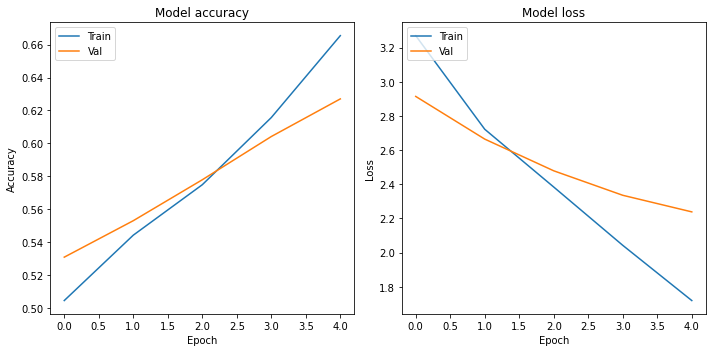

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)  
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

## **🌿 05_가사 한줄 생성**

In [ ]:
print(generate_text(model, tokenizer, init_sentence="<start> i", max_len=25))
print(generate_text(model, tokenizer, init_sentence="<start> i love", max_len=25))
print(generate_text(model, tokenizer, init_sentence="<start> i know", max_len=25))
print('\n')
print(generate_text(model, tokenizer, init_sentence="<start> you", max_len=25))
print(generate_text(model, tokenizer, init_sentence="<start> you have", max_len=25))
print(generate_text(model, tokenizer, init_sentence="<start> you love", max_len=25))

<start> i m gonna be the one to blame <end> 
<start> i love you , liberian girl <end> 
<start> i know you re wondering when <end> 


<start> you re the only one who knows that <end> 
<start> you have given it to yourself <end> 
<start> you love me , yeaah , i love you <end> 


# **🌲 EXPLORATION 06-3 : 회고**

## **🌿 01_EXPLORATION  회고**  

## **🌿 02_이번 회차 회고**  